In [1]:
# General imports
import pandas
import datetime
import numpy
import numba
from math import radians, cos, sin, asin, sqrt
# ML imports
import hdbscan
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
# plotting imports
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.colors import Normalize
from matplotlib import ticker
from matplotlib.dates import date2num, DateFormatter, MinuteLocator
from matplotlib.ticker import FuncFormatter, MaxNLocator
from davitpy import utils
%pylab inline

/usr/local/lib/python2.7/dist-packages/pandas/_libs/__init__.py:4: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from .tslib import iNaT, NaT, Timestamp, Timedelta, OutOfBoundsDatetime
/usr/local/lib/python2.7/dist-packages/pandas/__init__.py:26: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from pandas._libs import (hashtable as _hashtable,
/usr/local/lib/python2.7/dist-packages/pandas/core/dtypes/common.py:6: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from pandas._libs import algos, lib
/usr/local/lib/python2.7/dist-packages/pandas/core/util/hashing.py:7: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from pandas._libs import hashing, tslib
/usr/local/lib/python2.7/dist-packages/pandas/core/indexes/base.py:7: RuntimeWarning: numpy.dtype size changed, may indicate bi

/home/bharat/.cache/Python-Eggs/hdbscan-0.8.18-py2.7-linux-x86_64.egg-tmp/hdbscan/_hdbscan_tree.so:6: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
                       �                                           �                     �                     a                     �	                     �                                          G                     �                     W                     �                       	                     d                     R                     �                      �	                     �                      ]                                          �                     .                     ?                     }                     �	                     �                     �                                          �
/home/bharat/.cache/Python-Eggs/hdbscan-0.8.18-py2.7-linux-x86_64.egg-tmp/hdbscan/_hdbscan_reachabili

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python2.7/dist-packages/scipy/signal/_max_len_seq.py:8: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._max_len_seq_inner import _max_len_seq_inner
/usr/local/lib/python2.7/dist-packages/scipy/signal/_upfirdn.py:36: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._upfirdn_apply import _output_len, _apply
/usr/local/lib/python2.7/dist-packages/scipy/ndimage/measurements.py:36: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from . import _ni_label
/usr/local/lib/python2.7/dist-packages/scipy/signal/spectral.py:10: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._spectral import lombscargle
/usr/local/lib/python2.7/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['cos', 'sqrt', 'sin', 'radi

In [2]:
def custom_round(x, base=5):
    return int(base * round(float(x)/base))

In [3]:
tecDF = pandas.read_feather("./mftec-20130117-2025.feather")
# Re-scale Mlon to -180 to 180 (from 0 to 360)
tecDF["adjstMlons"] = [ b - 360. if b > 180. else\
             b for b in tecDF["Mlon"] ]
tecDF = tecDF[ tecDF["Mlat"] >= 50. ]
tecDF["rnd_tec"] = tecDF["med_tec"].apply(lambda x: custom_round(x, base=10))

tecDF.head()

/usr/local/lib/python2.7/dist-packages/pandas/io/feather_format.py:112: FutureWarning: `nthreads` argument is deprecated, pass `use_threads` instead
  return feather.read_dataframe(path, nthreads=nthreads)


,date,Mlat,Mlon,med_tec,adjstMlons,rnd_tec
4259,2013-01-17 20:25:00,50.0,0.0,30.3,0.0,30
4260,2013-01-17 20:25:00,50.0,2.0,30.0,2.0,30
4261,2013-01-17 20:25:00,50.0,4.0,29.8,4.0,30
4262,2013-01-17 20:25:00,50.0,6.0,29.1,6.0,30
4263,2013-01-17 20:25:00,50.0,8.0,28.3,8.0,30


In [4]:
coords = "mag"
patchDate = pandas.to_datetime(tecDF["date"].values[0])

In [5]:
def weight_matrix_pcp(tecDF):
    # create a distance matrix
    # matrix dimensions
    latList = tecDF["Mlat"].values
    lonList = tecDF["Mlon"].values
    tecList = tecDF["rnd_tec"].values
    nRecs = tecDF.shape[0]
    wghtMatrix = np.zeros((nRecs, nRecs))
    aa = []
    bb = []
    for i in range(nRecs):
        for j in range(nRecs):
            if wghtMatrix[i, j] == 0.0:
                
                # convert decimal degrees to radians 
                lon1, lat1, lon2, lat2 = map( radians, [lonList[i], latList[i],\
                                                       lonList[j], latList[j]] )
                # haversine formula 
                dlon = lon2 - lon1 
                dlat = lat2 - lat1 
                a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
                c = 2 * asin(sqrt(a))
                
                tecDiff = sqrt(numpy.abs( tecList[i] - tecList[j] ))/4.
                wghtMatrix[i, j] = c + tecDiff
                wghtMatrix[j, i] = wghtMatrix[i,j]
    return wghtMatrix

In [6]:
wghtMatrix = weight_matrix_pcp(tecDF)

In [7]:
print numpy.min(wghtMatrix), numpy.mean(wghtMatrix), numpy.max(wghtMatrix)

0.0 1.2047553335790497 3.1640303545618327


In [33]:
dbcsc = DBSCAN(eps=0.07, min_samples=5, metric="precomputed").fit(wghtMatrix)
labels = dbcsc.labels_
clabels = numpy.unique(labels)
core_samples_mask = numpy.zeros_like(dbcsc.labels_, dtype=bool)
core_samples_mask[dbcsc.core_sample_indices_] = True
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

print('Estimated number of clusters: %d' % n_clusters_)
if n_clusters_ > 1:
    # get a count of how many elements are in each bin
    uniqEl, counts = numpy.unique(labels,return_counts=True)
    print zip(uniqEl, counts)
# store the cluster counts in a dict
clstrCntDict = dict( zip(uniqEl, counts) )

Estimated number of clusters: 25
[(-1, 21), (0, 124), (1, 2323), (2, 127), (3, 28), (4, 40), (5, 43), (6, 368), (7, 256), (8, 288), (9, 6), (10, 22), (11, 10), (12, 34), (13, 7), (14, 26), (15, 5), (16, 52), (17, 854), (18, 28), (19, 6), (20, 29), (21, 15), (22, 9), (23, 7), (24, 10)]


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if __name__ == '__main__':


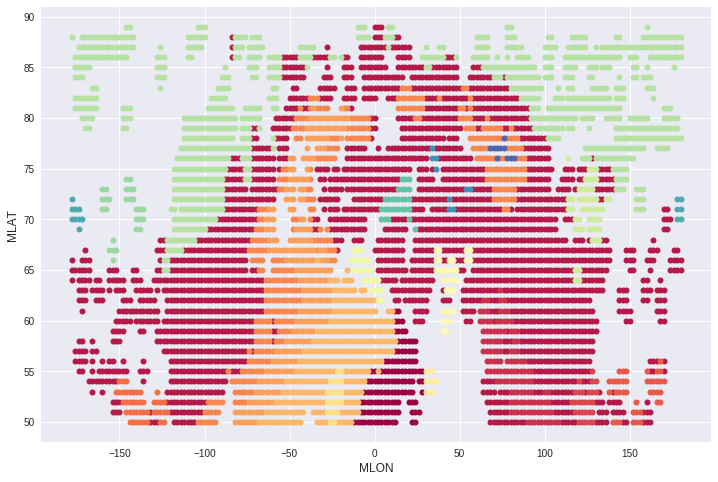

In [34]:
# set colorbar
seaMap = ListedColormap(sns.color_palette("Spectral_r"))
f = plt.figure(figsize=(12, 8))
ax = f.add_subplot(1,1,1)

unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
tecDataArr = tecDF[ [ "Mlat", "adjstMlons", "rnd_tec" ] ].as_matrix()
for k, col in zip(unique_labels, colors):    
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]
        continue
    if clstrCntDict[k] <= 7 :
        continue
    class_member_mask = (labels == k)
    xy = tecDataArr[class_member_mask & core_samples_mask]
    ax.plot(xy[:, 1], xy[:, 0], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)
    
    xy = tecDataArr[class_member_mask & ~core_samples_mask]
    ax.plot(xy[:, 1], xy[:, 0], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)
ax.set_xlabel("MLON", fontsize=12)
ax.set_ylabel("MLAT", fontsize=12)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


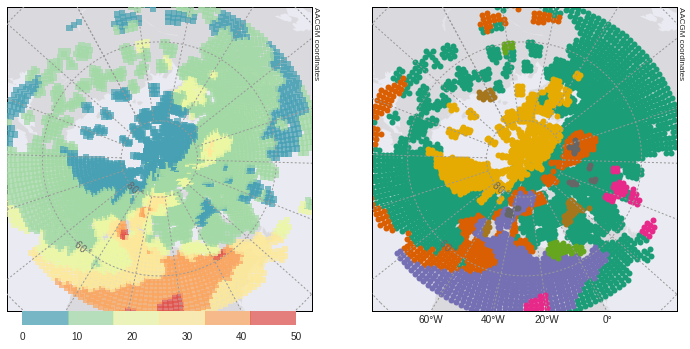

In [35]:
# TEC data arr
tecDataArr = tecDF[ [ "Mlat", "adjstMlons", "rnd_tec" ] ].as_matrix()
# set colorbar
seaMap = ListedColormap(sns.color_palette("Spectral_r"))
f = plt.figure(figsize=(12, 8))
ax1 = f.add_subplot(1,2,1)
ax2 = f.add_subplot(1,2,2)
# Original map
m1 = utils.plotUtils.mapObj(boundinglat=50,\
            coords=coords, ax=ax1, datetime=patchDate)

xVec, yVec = m1(list(tecDF["Mlon"]),\
                list(tecDF["Mlat"]), coords=coords)
tecPlot = m1.scatter( xVec, yVec , c=tecDF["rnd_tec"], s=40.,\
           cmap=seaMap, alpha=0.7, zorder=5., \
                     edgecolor='none', marker="s" )
cbar = plt.colorbar(tecPlot, orientation='horizontal',ax=ax1, shrink=0.9, pad=0.0)
# cbar.set_label('TEC', size=15)
# Clustered map
m2 = utils.plotUtils.mapObj(boundinglat=50,\
            coords=coords, ax=ax2, datetime=patchDate)
colors = [plt.cm.Dark2(each)
          for each in np.linspace(0, 1, len(unique_labels))]

for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]
        continue
#     if clstrCntDict[k] < 5 :
#         continue
    class_member_mask = (labels == k)
    
    xy = tecDataArr[class_member_mask & core_samples_mask]
    clsPlt = m2.plot(xy[:, 1], xy[:, 0], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6, latlon=True)

    xy = tecDataArr[class_member_mask & ~core_samples_mask]
    m2.plot(xy[:, 1], xy[:, 0], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6, latlon=True)

In [13]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=7, metric="precomputed")
hdbsc = clusterer.fit(wghtMatrix)

In [22]:
# core_samples_mask = numpy.zeros_like(hdbsc.labels_, dtype=bool)
# core_samples_mask[hdbsc.core_sample_indices_] = True
labels = hdbsc.labels_
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
unique_labels = set(labels)
print('Estimated number of clusters: %d' % n_clusters_)
if n_clusters_ > 1:
    # get a count of how many elements are in each bin
    uniqEl, counts = numpy.unique(labels,return_counts=True)
    print zip(uniqEl, counts)
clstrCntDictHdbscn = dict( zip(uniqEl, counts) )

Estimated number of clusters: 30
[(-1, 69), (0, 34), (1, 13), (2, 288), (3, 10), (4, 124), (5, 261), (6, 14), (7, 2327), (8, 43), (9, 52), (10, 127), (11, 28), (12, 23), (13, 15), (14, 26), (15, 15), (16, 32), (17, 34), (18, 838), (19, 8), (20, 16), (21, 17), (22, 147), (23, 22), (24, 94), (25, 8), (26, 7), (27, 17), (28, 21), (29, 8)]


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


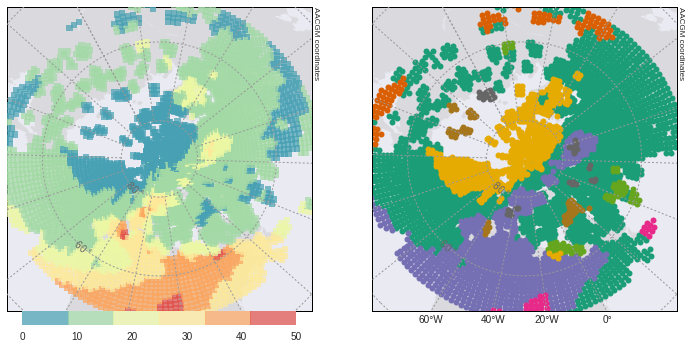

In [39]:
# TEC data arr
tecDataArr = tecDF[ [ "Mlat", "adjstMlons", "rnd_tec" ] ].as_matrix()
# set colorbar
seaMap = ListedColormap(sns.color_palette("Spectral_r"))
f = plt.figure(figsize=(12, 8))
ax1 = f.add_subplot(1,2,1)
ax2 = f.add_subplot(1,2,2)
# Original map
m1 = utils.plotUtils.mapObj(boundinglat=50,\
            coords=coords, ax=ax1, datetime=patchDate)

xVec, yVec = m1(list(tecDF["Mlon"]),\
                list(tecDF["Mlat"]), coords=coords)
tecPlot = m1.scatter( xVec, yVec , c=tecDF["rnd_tec"], s=40.,\
           cmap=seaMap, alpha=0.7, zorder=5., \
                     edgecolor='none', marker="s" )
cbar = plt.colorbar(tecPlot, orientation='horizontal',ax=ax1, shrink=0.9, pad=0.0)
# cbar.set_label('TEC', size=15)
# Clustered map
m2 = utils.plotUtils.mapObj(boundinglat=50,\
            coords=coords, ax=ax2, datetime=patchDate)
colors = [plt.cm.Dark2(each)
          for each in np.linspace(0, 1, n_clusters_)]

for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]
#         continue
#     if clstrCntDictHdbscn[k] > 15 :
#         continue
    class_member_mask = (labels == k)
    
    xy = tecDataArr[class_member_mask]
    clsPlt = m2.plot(xy[:, 1], xy[:, 0], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6, latlon=True)